# Лабораторная работа №3. Синтез БИХ-фильтров




## Модуль 1. Метод размещения нулей и полюсов.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.ticker as ticker
# %matplotlib widget

In [2]:
# Python класс для анализа фильтра
class Filter():
    def __init__(self, dlti_args, fs=1.0):
#         Инициализация на основе объекта signal.dlti
        self.fs = fs
        self.system_dlti=signal.dlti(*dlti_args, dt=1.0/fs)
        self.alpha_beta()
        self.zpk()
    def alpha_beta(self):
#         Вычисление коэффициентов alpha beta
        system = signal.TransferFunction(self.system_dlti)
        self.beta = system.num
        self.alpha = system.den
    def zpk(self):
#         Вычисление нулей, полюсов и множителя        
        system = self.system_dlti.to_zpk()
        self.zeros = system.zeros
        self.poles = system.poles
        self.gain = system.gain
    def zpk_plot(self):
#         Нуль-полюсная диаграмма
        plt.figure()
        q = np.linspace(0, 2*np.pi, 401)
        ax = plt.axes()
        ax.set_aspect(aspect='equal', adjustable='datalim')
        plt.plot(np.cos(q), np.sin(q), 'k--')  
        plt.plot(self.zeros.real, self.zeros.imag, 'ro', label='Нули')
        plt.plot(self.poles.real, self.poles.imag, 'bx', label='Полюса')
        plt.grid()
        plt.legend() #bbox_to_anchor=(1.05, 1), loc=2, numpoints=1
        plt.title("Нуль-полюсная диаграмма")
        plt.xlabel("Re $z$")
        plt.ylabel("Im $z$")
        plt.tight_layout()
        plt.show()
    def H(self, z):
#         Вычисление функции H(z) для заданного z. Требует предварительного вычисления нулей и полюсов.
        H = self.gain+0
        for z1 in self.zeros:
            H *= (z-z1)
        for p1 in self.poles:
            H /= (z-p1)
        return H
    
    def abs_H_plot(self):
#         Трехмерный график |H(z)|
        fig = plt.figure(dpi=160)
        ax = plt.axes(projection='3d')
        Re=np.arange(-1.2, 1.2, 0.1)
        Im=np.arange(-1.2, 1.2, 0.1)
        Re, Im = np.meshgrid(Re, Im)
        Z1=(Re+1j*Im)
        
        
        Z=abs(self.H(Z1))
        Z=np.minimum(Z, 40*np.ones(Z.shape))


        phi=np.linspace(0, 2*np.pi, 500)
        #ax.plot_surface(Re, Im, Z, linewidth=0, antialiased=True, color='silver')
        ax.plot_wireframe(Re, Im, Z, color='silver')

        for u in phi:
            Z1=np.exp(-1j*u)
            Z2=abs(self.H(Z1))
            ax.plot([Z1.real, Z1.real], [Z1.imag, Z1.imag], [0.0, Z2],  color=(abs(np.cos(u)), 0.7, 0.5))


        Z1=np.exp(-1j*phi)
        Z2=abs(self.H(Z1))

        ax.plot(Z1.real, Z1.imag, Z2, linewidth=2, color='b')

        ax.set_zlim(0, 1.2*max(Z2))
        ax.set_xticks(np.linspace(-1, 1, 5))
        ax.set_yticks(np.linspace(-1, 1, 5))
        ax.set_zticks(np.linspace(0, max(Z2), 5))
        ax.view_init(40, 240)
        ax.set_xlabel("Re $z$")
        ax.set_ylabel("Im $z$")

        ax.zaxis.set_rotate_label(False)  # disable automatic rotation
        ax.set_zlabel("$|H(z)|$", rotation=0)
        plt.tight_layout()
    def lfilter_resp(self, x):
#         Фильтрация заданного сигнала
        return signal.lfilter(self.beta, self.alpha, x)
    def lfilt_plot(self, x, label='y'):
        self.alpha_beta()
#         График сигнала на выходе фильтра при заданном входе
        y = self.lfilter_resp(x)
        plt.figure(figsize=[8, 3])
        plt.title("Сигнал на выходе фильтра")
        plt.stem(np.arange(y.shape[0]), y)
        plt.xlabel("$k$")
        plt.ylabel("$%s[k]$" %label)
        plt.tight_layout()
        plt.grid()
    def step_resp_plot(self, n=20):
        t, y = signal.dstep(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Переходная характеристика")
        y=np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$g[k]$")
        plt.tight_layout()
        plt.grid()
    def impulse_resp_plot(self, n=20):
        t, y = signal.dimpulse(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Импульсная характеристика")
        y=np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$h[k]$")
        plt.tight_layout()
        plt.grid()
    def freqresp_plot(self, f_scale='f', whole=True):
#         АЧХ фильтра
        w, H = self.system_dlti.freqresp(w=None, n=2**18, whole=whole)
        if whole:
            w, H = w-np.pi, np.fft.fftshift(H)
        figure1 = plt.figure(figsize=[8, 6])
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)
        
        
        
        for ax in [ax1, ax2]:
            if f_scale=='f':
                f = self.fs*(w/(2*np.pi))/1e3
                ax.set_xlabel("$f$, кГц")    
            elif f_scale=='\\nu':
                f = w/(2*np.pi)
                ax.set_xlabel("$%s$" % f_scale)
            elif f_scale=='\\theta':
                f = w
                ax.set_xlabel("$%s$, рад" % f_scale) 
            ax.set_xlim([f[0], f[-1]])
            ax.grid()
            
        ax1.set_title("AЧХ фильтра")    
        ax1.plot(f, abs(H))
        ax1.set_ylabel("$|H(%s)|$" % f_scale)
        
        
        ax2.plot(f, np.angle(H))
        ax2.set_ylabel("$\\varphi(%s)$" % f_scale)
        ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=("$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"))
        plt.tight_layout()
        

### Задача 1.1 Синтез цифрового резонатора

| Варианты: |   $1$ |    $2$ |    $3$ |    $4$ |    $5$ |    $6$ |     $7$ |    $8$ |    $9$ |    $10$ | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $\nu_0$  | $0.25$ | $0.2$ | $0.1$ |  $—$ | $—$ | $—$ | $0.3$ | $0.15$ | $0.35$ | $0.4$ |
|$\theta_0$ | $—$ | $—$ | $—$ | $\dfrac\pi6$ | $\dfrac\pi3$ | $\dfrac\pi2$ |  $—$ | $—$ | $—$ | $—$ |

Синтезировать методом размещения нулей и полюсов цифровой резонатор для частоты $\nu_0$ или $\theta_0$ (в зависимости от варианта). Параметр, влияющий на добротность резонатора, подобрать самостоятельно.

* Построить нуль-полюсную диаграмму получившегося фильтра.
* Записать передаточную функцию $H(z)$.
* Вычислить аналитически импульсную и переходную характеристики и сравнить с результатами моделирования.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.

In [6]:
nu_0 = 0.15
beta, alpha = signal.iirpeak(nu_0, Q=10, fs=1)
filt = Filter(dlti_args=(beta, alpha))

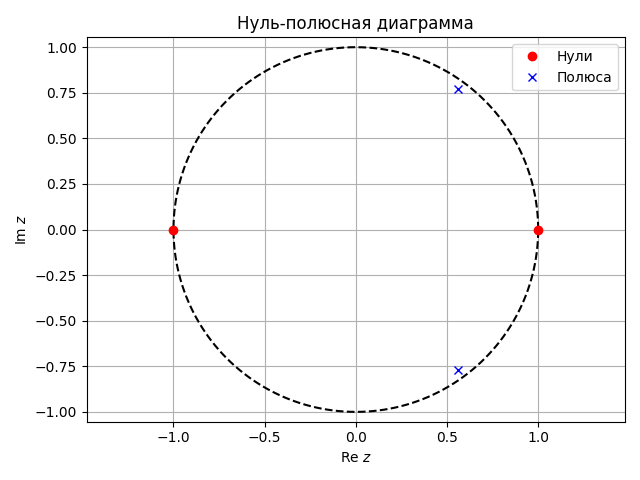

In [5]:
filt.zpk_plot()

In [4]:
from IPython.display import display, Latex
def latex_elem(elem, power, last=False) -> str:
  res = ""
  if elem != 0.0:
    res = f"\\left({elem}\\right)"
    if power != 0:
      res += f"\\cdot z^{{{power}}}"
    if not last:
      res += " + "
  return res

display(Latex(f"""\
$$
H\\left(z\\right) =
\\dfrac{{
  {"".join(latex_elem(b, -i, i == 2) for i, b in enumerate(beta))}
}}{{
  {"".join(latex_elem(a, -i, i == 2) for i, a in enumerate(alpha))}
}}
$$"""))

<IPython.core.display.Latex object>

$$
H(z) = \dfrac{G_0\left(z^2 - 1\right)}{\left(z - \alpha e^{-j2\pi\nu_0}\right)\left(z - \alpha e^{j2\pi\nu_0}\right)} = \dfrac{G_0 - G_0z^{-2}}{1 - 2\alpha\cos\left(2\pi\nu_0\right)z^{-1} + \alpha^2z^{-2}},
$$
$$
\alpha = \dfrac{1}{1 + \tan\left(\frac{\nu_0\pi}{Q}\right)} \approx 0.955,
$$
$$
G_0 = 1 - \alpha \approx 0.045.
$$

Из $H\left(z\right)$ можем получить разностное уравнение:
$$
y[k] = G_0x[k] - G_0x[k - 2] + 2\alpha\cos\left(2\pi\nu_0\right)y[k - 1] - \alpha^2y[k - 2] \approx 0.045x[k] - 0.045x[k - 2] + 1.123y[k - 1] - 0.912y[k - 2]
$$

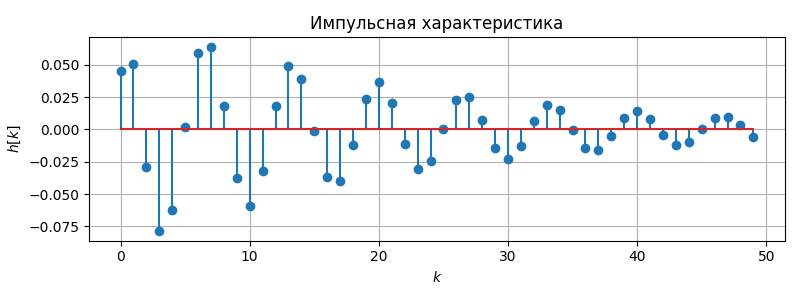

In [12]:
filt.impulse_resp_plot(n=50)

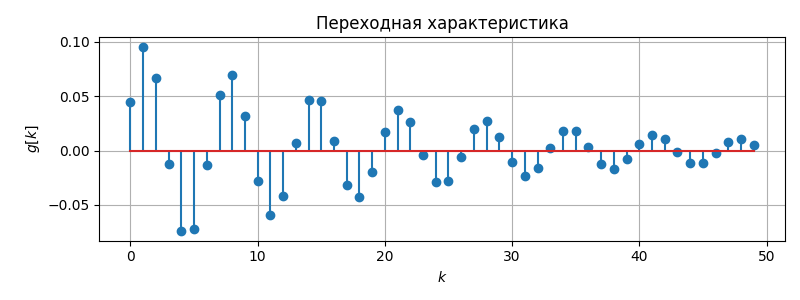

In [13]:
filt.step_resp_plot(n=50)

Полюса лежат внутри единичной окружности $\Rightarrow$ фильтр устойчив (рис. 1)

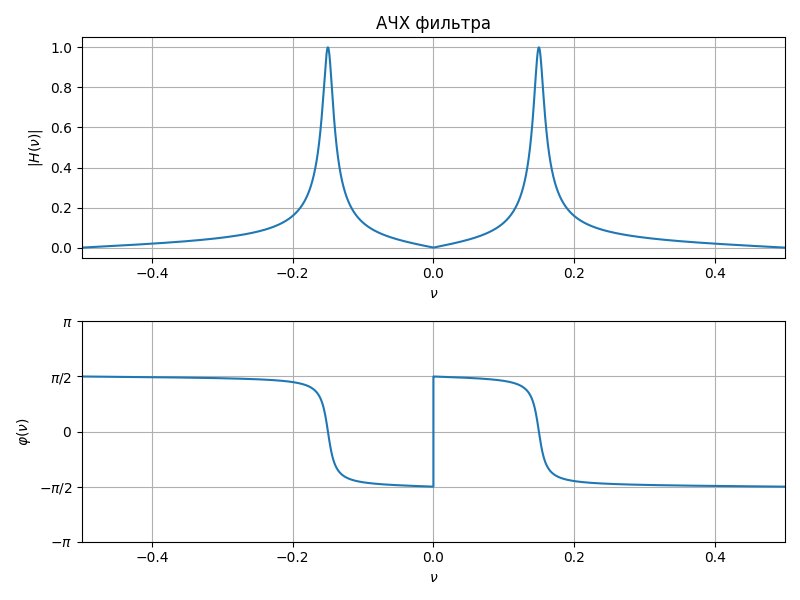

In [14]:
filt.freqresp_plot(f_scale='\\nu')

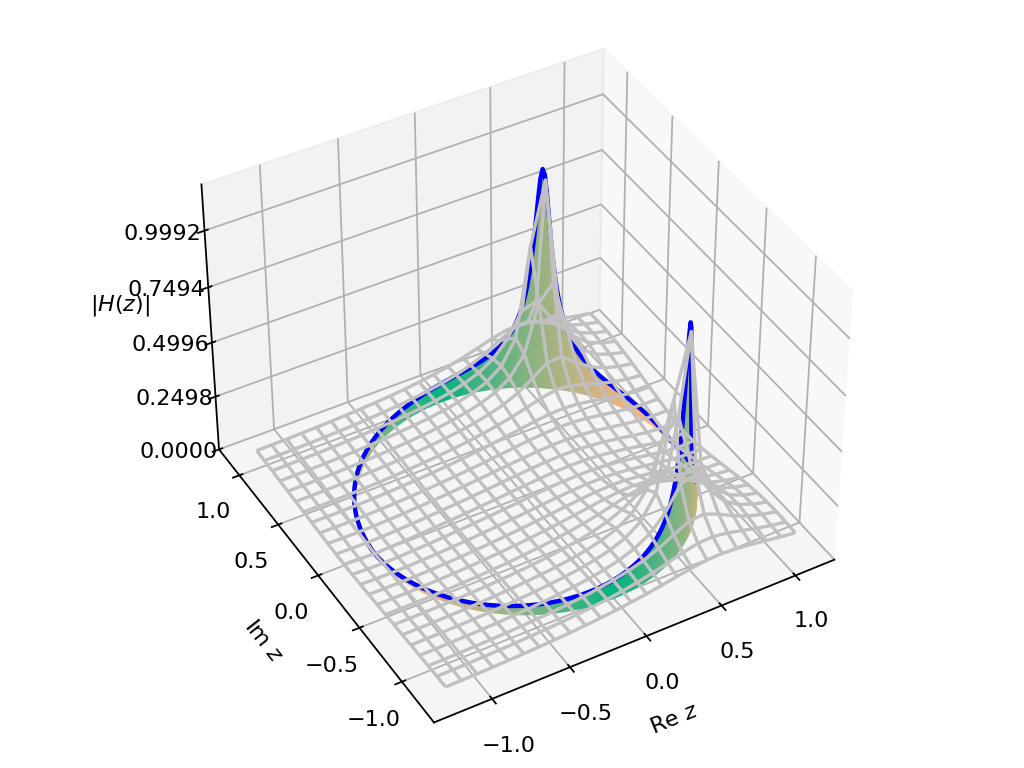

In [16]:
filt.abs_H_plot()

### Задача 1.2 Синтез цифрового фильтра Hum removal

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |  
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $f_0$, Гц  | 250 | 350 | 400 |  200 | 100 | 150 | 250 | 500| 600 | 350 |
|  $f_д$, Гц | 1000 | 1000 | 1000 | 500 | 500 | 500 | 1000 | 2000 | 2000 | 2000 |

Синтезировать методом размещения нулей и полюсов цифровой фильтр Hum removal  для частоты $f_{0}$, $f_{д}$. Параметр, влияющий на добротность, подобрать самостоятельно.

* Записать передаточную функцию $H(z)$.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.


In [21]:
f_0, f_s = 500, 2000
nu_0 = f_0 / f_s
theta_0 = nu_0 * 2 * np.pi
A = 0.8
z = np.array([np.exp(1j * theta_0), np.exp(-1j * theta_0)])
p = np.array([A * np.exp(1j * theta_0), A * np.exp(-1j * theta_0)])
k = 1

hum = Filter((z, p, k), fs=f_s)

$$
H\left(z\right) = \dfrac{z^2 + \theta_0^2}{\left(z - Ae^{\theta_0j}\right)\left(z - Ae^{-\theta_0j}\right)}
$$

Полюса лежат внутри единичной окружности $\Rightarrow$ фильтр устойчив (рис. 2)

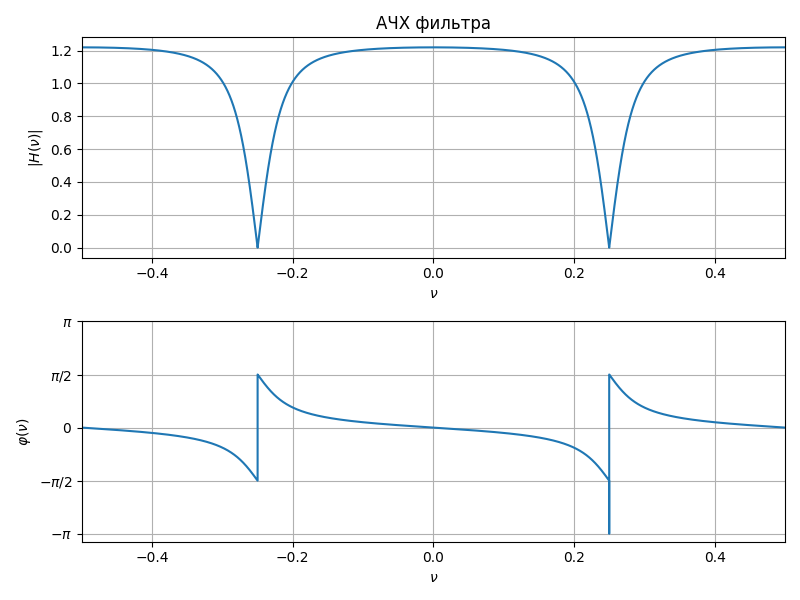

In [23]:
hum.freqresp_plot(f_scale="\\nu")

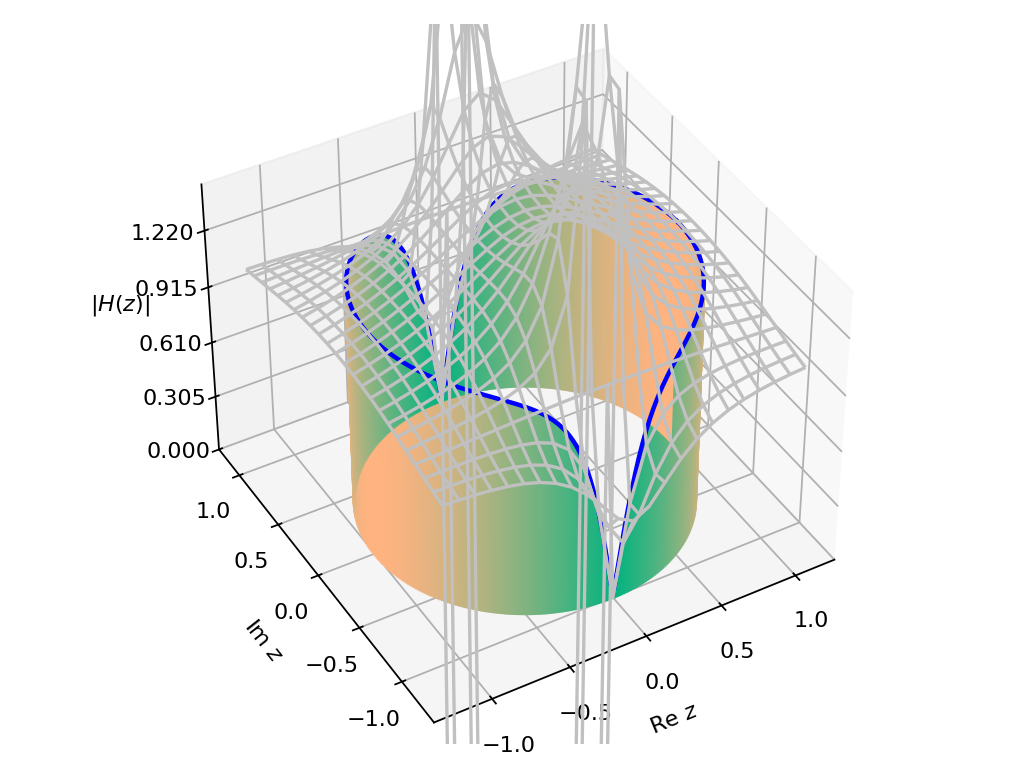

In [26]:
hum.abs_H_plot()

## Модуль 2. Метод билинейного *z*-преобразования

### Задача 2.1 Синтез фильтра нижних частот (ФНЧ)

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |    10 | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $f_д$, Гц  | 6000 | 6200 | 6400 |  6600 | 6800 | 7000 | 6200 | 6400 |  6600 | 6800 |
|  $f_1$, Гц | 800 | 860 | 920 | 980 | 1040 | 1100 | 860 | 920 | 980 | 1040 |
|  $f_2$, Гц | 1100 | 1170 | 1240 | 1310 | 1380 | 1450 |1170 | 1240 | 1310 | 1380 |
|  $a_\max$, дБ | 0.4455 | 0.4455 | 0.4455 | 0.4455 | 0.4455 | 0.4455 |0.4455 | 0.4455 | 0.4455 | 0.4455 |
|  $a_\min$, дБ | 40 | 40 | 40 | 40 | 40 | 40 |40 | 40 | 40 | 40 |

 Получить коэффициенты разностного уравнения БИХ-фильтра нижних частот со следующими характеристиками:
* частота дискретизации $f_{д}$, 
* граничная частота полосы пропускания $f_1$,
* граничная частота полосы задерживания $f_2$,
* максимальное допустимое затухание в полосе пропускания $a_\max$,
* минимальное допустимое затухание в полосе задерживания $a_\min$.

Воспользоваться методом билинейного z-преобразования для фильтров: 

1) Баттервота,

2) Чебышёва 1 рода,

3) Чебышёва 2 рода,

4) Золотарёва—Кауэра.

Из четырех получившихся результатов выбрать фильтр, обладающий наименьшим порядком $N$ и построить схему его реализации в виде каскада биквадратных блоков. Для биквадратных блоков выбрать прямую каноническую реализацию. 


In [27]:
# Опредление набора параметров 
fs = 6400 # частота дискретизации 
f1 = 920 # граничная частота полосы пропускания
f2 = 1240 # граничная частота полосы задерживания
gpass=0.4455 # максимальное допустимое затухание в полосе пропускания в дБ
gstop=40 # минимальное допустимое затухание в полосе задерживанияd в дБ
wp, ws = f1, f2

In [42]:
filt_infos = dict()

In [55]:
# Синтез на основе фильтра Баттервота
N, Wn = signal.buttord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fs)
beta, alpha = signal.butter(N, Wn=Wn, btype='lowpass', analog=False, output='ba', fs=fs)
print("Порядок фильтра ", N)
print("Частота среза %.2f Гц" % Wn)
filt_infos['butt'] = {
    'alpha': alpha,
    'beta': beta,
    'Wn': Wn,
}
filt_infos['butt']

Порядок фильтра  16
Частота среза 976.81 Гц


{'alpha': array([ 1.00000000e+00, -6.22418767e+00,  1.97039603e+01, -4.11624770e+01,
         6.27943785e+01, -7.36121144e+01,  6.82230410e+01, -5.07809947e+01,
         3.05799236e+01, -1.49084818e+01,  5.85189305e+00, -1.82655073e+00,
         4.43732307e-01, -8.09963420e-02,  1.04638388e-02, -8.53896567e-04,
         3.31278238e-05]),
 'beta': array([1.64323104e-07, 2.62916966e-06, 1.97187725e-05, 9.20209382e-05,
        2.99068049e-04, 7.17763318e-04, 1.31589942e-03, 1.87985631e-03,
        2.11483835e-03, 1.87985631e-03, 1.31589942e-03, 7.17763318e-04,
        2.99068049e-04, 9.20209382e-05, 1.97187725e-05, 2.62916966e-06,
        1.64323104e-07]),
 'Wn': np.float64(976.8145214831268)}

In [56]:
# Синтез на основе фильтра Чебышёва 1 рода
N, Wn = signal.cheb1ord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fs)
beta, alpha= signal.cheby1(N=N, rp=gpass, Wn=Wn, btype='low', analog=False, output='ba', fs=fs)
print("Порядок фильтра ", N)
print("Частота среза %.2f Гц" % Wn)
filt_infos['cheb1'] = {
    'alpha': alpha,
    'beta': beta,
    'Wn': Wn,
}
filt_infos['cheb1']

Порядок фильтра  8
Частота среза 920.00 Гц


{'alpha': array([  1.        ,  -5.47175907,  14.27511978, -22.87236549,
         24.44898643, -17.78810234,   8.58961737,  -2.51802183,
          0.34398332]),
 'beta': array([2.76768910e-05, 2.21415128e-04, 7.74952947e-04, 1.54990589e-03,
        1.93738237e-03, 1.54990589e-03, 7.74952947e-04, 2.21415128e-04,
        2.76768910e-05]),
 'Wn': np.float64(919.9999999999999)}

In [57]:
# Синтез на основе фильтра Чебышёва 2 рода
N, Wn = signal.cheb2ord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fs)
beta, alpha= signal.cheby2(N=N, rs=gstop, Wn=Wn, btype='low', analog=False, output='ba', fs=fs)
print("Порядок фильтра ", N)
print("Частота среза %.2f Гц" % Wn)
filt_infos['cheb2'] = {
    'alpha': alpha,
    'beta': beta,
    'Wn': Wn,
}
filt_infos['cheb2'] 

Порядок фильтра  8
Частота среза 1173.17 Гц


{'alpha': array([ 1.00000000e+00, -2.26340740e+00,  3.30917248e+00, -2.81064754e+00,
         1.76036802e+00, -6.84158034e-01,  1.99904784e-01, -2.68909114e-02,
         3.18906956e-03]),
 'beta': array([0.03115815, 0.02218921, 0.07449108, 0.06954907, 0.09275545,
        0.06954907, 0.07449108, 0.02218921, 0.03115815]),
 'Wn': np.float64(1173.1691732692836)}

In [58]:
# Синтез на основе фильтра Золотарёва—Кауэра.
N, Wn = signal.ellipord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fs)
beta, alpha = signal.ellip(N=N, rp=gpass, rs=gstop, Wn=Wn, btype='low', analog=False, output='ba', fs=fs)
print("Порядок фильтра ", N)
print("Частота среза %.2f Гц" % Wn)
filt_infos['ellip'] = {
    'alpha': alpha,
    'beta': beta,
    'Wn': Wn,
}
filt_infos['ellip']

Порядок фильтра  5
Частота среза 920.00 Гц


{'alpha': array([ 1.        , -2.96054076,  4.33103631, -3.55772058,  1.64881748,
        -0.34098861]),
 'beta': array([2.81469836e-02, 8.76369411e-05, 3.20672967e-02, 3.20672967e-02,
        8.76369411e-05, 2.81469836e-02]),
 'Wn': np.float64(919.9999999999999)}

In [32]:
# Пределы в линейном масштабе
delta_pass = 1- 10**(-gpass/20)
delta_stop = 10**(-gstop/20)
delta_pass, delta_stop

(0.04999694912604835, 0.01)

In [53]:
def mag_resp_plot(info, name, dB=False):
    alpha, beta, Wn = info['alpha'], info['beta'], info['Wn']
    plt.figure(figsize=[10, 3], dpi=100)
    f_Nyquist=fs/2
    f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 1024**2), fs=fs)        
    if dB:
        plt.plot(f, 20*np.log10(abs(H)))
        plt.ylabel("дБ")
        plt.plot([-f_Nyquist,-ws], [-gstop, -gstop], '--r')
        plt.plot([f_Nyquist,ws], [-gstop, -gstop], '--r')
        plt.plot([-wp,wp], [-gpass, -gpass], '--r')
        plt.ylim([-gstop*2, 5])
    else:
        plt.plot(f, abs(H))
        plt.ylabel("$|H(f)|$")
        plt.fill([-wp,-wp, wp, wp], [0, 1-delta_pass, 1-delta_pass, 0], '0.9', lw=0)
        plt.fill([-f_Nyquist,-f_Nyquist, -ws, -ws], [delta_stop, 1, 1, delta_stop], '0.9', lw=0)
        plt.fill([f_Nyquist, f_Nyquist, ws, ws], [delta_stop, 1, 1, delta_stop], '0.9', lw=0)
        plt.fill([f_Nyquist, f_Nyquist, ws, ws], [delta_stop, 1, 1, delta_stop], '0.9', lw=0)
        plt.fill([-f_Nyquist,-f_Nyquist, f_Nyquist, f_Nyquist], [1.1, 1, 1, 1.1], '0.9', lw=0)
        plt.fill([-f_Nyquist,-f_Nyquist, f_Nyquist, f_Nyquist], [1.1, 1, 1, 1.1], '0.9', lw=0)
    plt.xlim([-fs/2, fs/2])
    plt.xticks([-fs/2, -Wn, 0, wp, ws, fs/2])
    plt.xlabel("$f$, Гц")
    plt.title(name)
    plt.grid()
    plt.tight_layout()

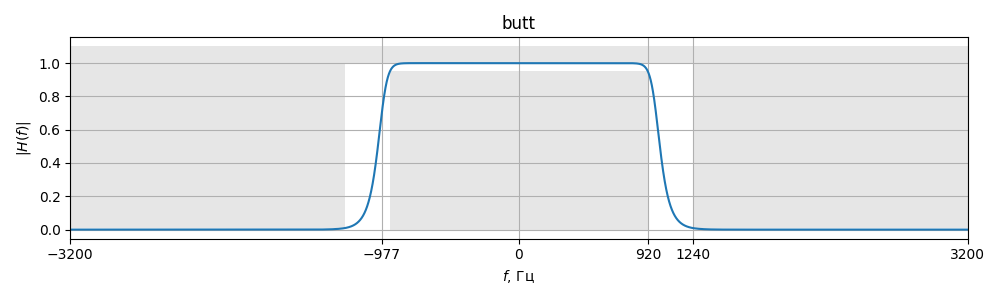

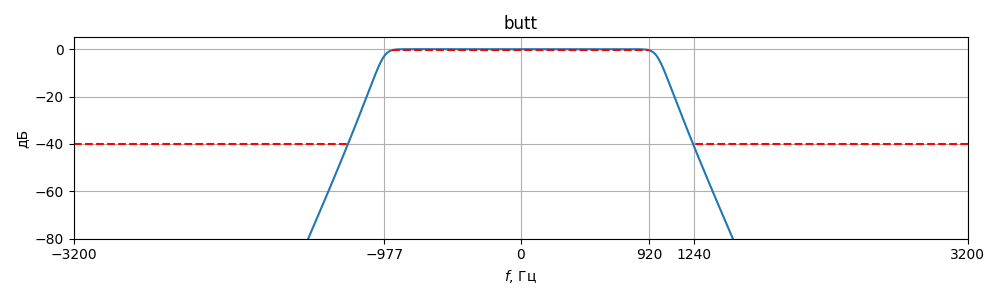

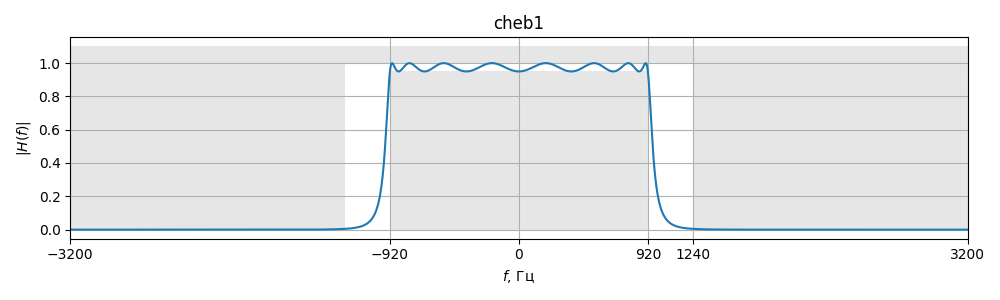

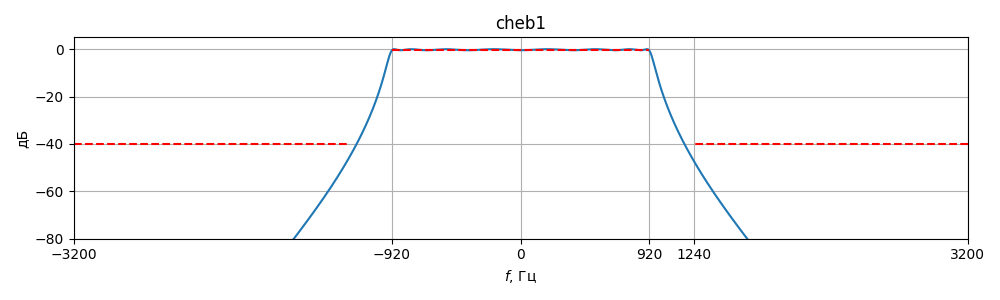

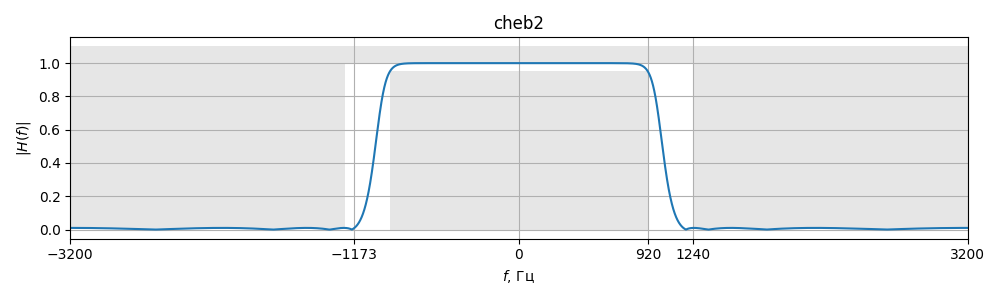

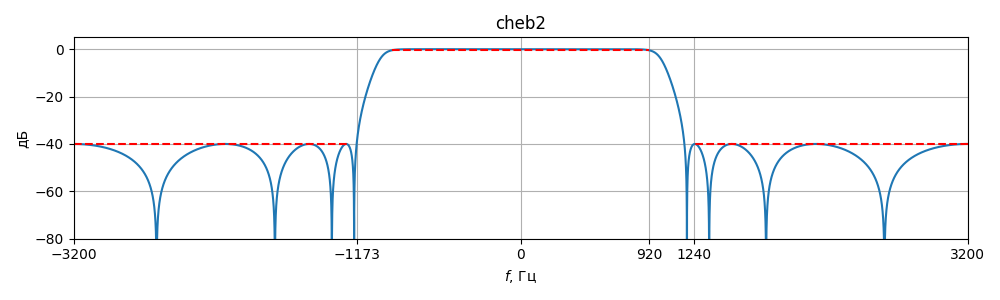

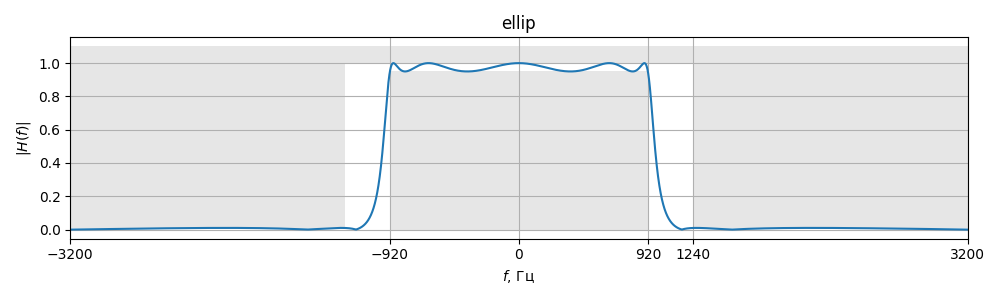

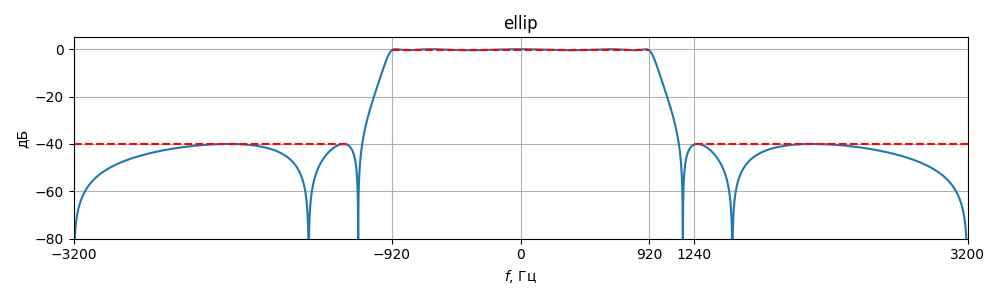

In [54]:
for name, info in filt_infos.items():
    mag_resp_plot(info, name, False)
    mag_resp_plot(info, name, True)

In [60]:
lowest = filt_infos["ellip"]
alpha, beta = lowest['alpha'], lowest['beta']
signal.tf2sos(beta, alpha)

array([[ 0.02814698,  0.02814698,  0.        ,  1.        , -0.61965274,
         0.        ],
       [ 1.        , -0.16336241,  1.        ,  1.        , -1.18620348,
         0.61276726],
       [ 1.        , -0.83352404,  1.        ,  1.        , -1.15468454,
         0.89804055]])

рис. 3

### Задача 2.2 Синтез аналога двухкаскадного RC-фильтра (I способ)

Построить БИХ фильтр, эквивалентный двум последовательно соединенным RC-цепочкам интегрирующего типа (соединённым через развязывающий усилитель), воспользовавшись методом билинейного *z*-преобразования.

Параметры $RC$ и $\Delta t $ выбрать самостоятельно. 
Сравнить частотные и импульсные характеристики  цифровых фильтров и их аналоговых прототипов. 

* Уравнение для одного RC-каскада:
$$RC\frac{dy}{dt}+{{y}_{1}}(t)=x(t)$$
Пусть ${{y}_{1}}(0)=0$. 

* Тогда преобразование Лапласа для него
$$RCp{{Y}_{1}}(p)+{{Y}_{1}}(p)=X(p)$$
* Передаточная функция
$${{H}_{1}}(p)=\frac{{{Y}_{1}}(p)}{X(p)}=\frac{1}{1+RCp}.$$

* Для двух последовательно соединенных RC-фильтров первого порядка
$${{H}_{2}}(p)={{H}_{1}}(p){{H}_{1}}(p)=\frac{1}{{{(RC)}^{2}}{{p}^{2}}+2RCp+1}.$$
Передаточную функцию $H(z)$ для соответствующего цифрового фильтра можно получить методом билинейного $z-$преобразования.
* Получаем передаточную функцию цифрового фильтра $H(z)$.
$$H(z)=\frac{1}{{{(RC)}^{2}}{{\left( \frac{2}{\Delta t}\frac{1-{{z}^{-1}}}{1+{{z}^{-1}}} \right)}^{2}}+2RC\left( \frac{2}{\Delta t}\frac{1-{{z}^{-1}}}{1+{{z}^{-1}}} \right)+1}$$
Преобразуем:
$$\begin{align}
  & H(z)=\frac{1+2{{z}^{-1}}+{{z}^{-2}}}{4{{(RC/\Delta t)}^{2}}(1-2{{z}^{-1}}+{{z}^{-2}})+4(RC/\Delta t)(1-{{z}^{-2}})+(1+2{{z}^{-1}}+{{z}^{-2}})} \\ 
\end{align}$$

Обозначим $\alpha =RC/\Delta t=RC{{f}_{\text{}}}$
$$H(z)=\frac{1+2{{z}^{-1}}+{{z}^{-2}}}{(4{{\alpha }^{2}}+4\alpha +1)+(2-8{{\alpha }^{2}}){{z}^{-1}}+(4{{\alpha }^{2}}-4\alpha +1){{z}^{-2}}}$$


In [109]:
# Аналоговый фильтр
RC=5*1e-4
lti_RC=signal.lti([1], [RC, 1])
lti_RC

TransferFunctionContinuous(
array([2000.]),
array([1.e+00, 2.e+03]),
dt: None
)

In [74]:
# Цифровой фильтр
dt=RC/4
beta=[1, 1]
alpha=[(1+2*RC/dt), (1-2*RC/dt)]
dlti_RC=signal.dlti(beta, alpha, dt=dt)
dlti_RC

TransferFunctionDiscrete(
array([0.11111111, 0.11111111]),
array([ 1.        , -0.77777778]),
dt: 0.000125
)

In [75]:
# пример расчета функцией signal.bilinear
signal.bilinear([1], [RC, 1], fs=1/dt)

(array([0.11111111, 0.11111111]), array([ 1.        , -0.77777778]))

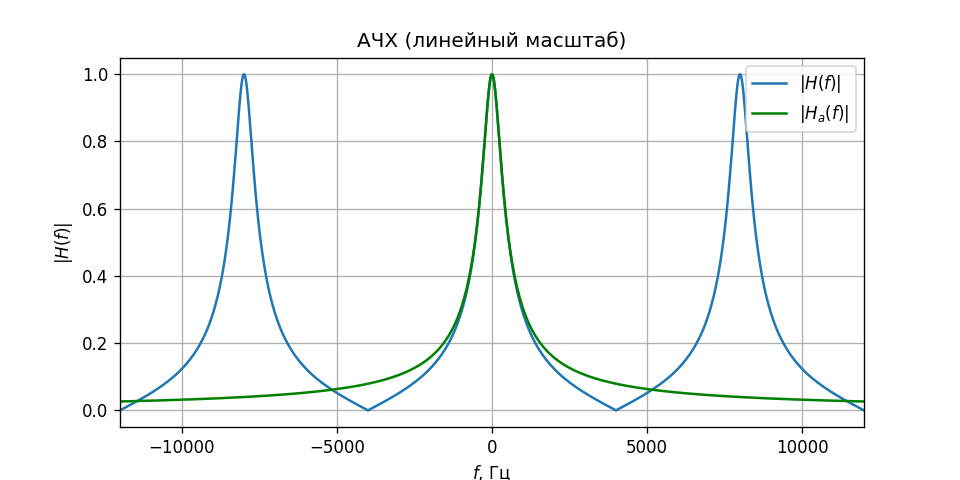

In [76]:
w_a, H_a=signal.freqresp(lti_RC, w=np.linspace(-3*np.pi, 3*np.pi, 1024)/dt)
theta_d, H_d=signal.dfreqresp(dlti_RC, w=np.linspace(-3*np.pi, 3*np.pi, 1024))

plt.figure(figsize=[8, 4], dpi=120)
plt.plot(theta_d/(2*np.pi*dt), abs(H_d), label="$|H(f)|$")
plt.plot(w_a/(2*np.pi), abs(H_a), "g", label="$|H_a(f)|$")
plt.xlabel("$f$, Гц")
plt.ylabel("$|H(f)|$")
plt.title("АЧХ (линейный масштаб)")
plt.xlim([-1.5/dt, 1.5/dt])
plt.legend(loc='upper right')
plt.grid()

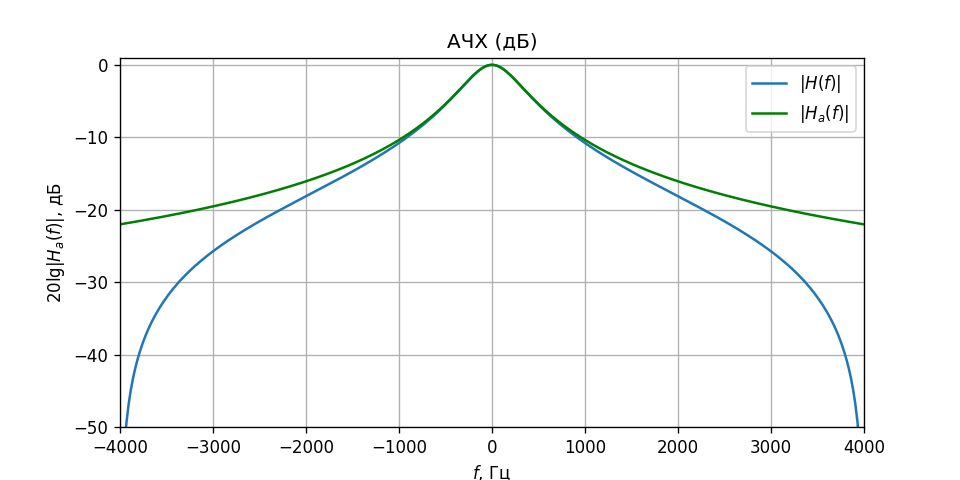

In [77]:
plt.figure(figsize=[8, 4], dpi=120)
plt.plot(theta_d/(2*np.pi*dt), 20*np.log10(abs(H_d)), label="$|H(f)|$")
plt.plot(w_a/(2*np.pi), 20*np.log10(abs(H_a)), "g", label="$|H_a(f)|$")
plt.xlabel("$f$, Гц")
plt.ylabel("$20\\lg|H_a(f)|$, дБ")
plt.title("АЧХ (дБ)")
plt.xlim([-0.5/dt, 0.5/dt])
plt.ylim([-50, 1])
plt.legend(loc='upper right')
plt.grid()

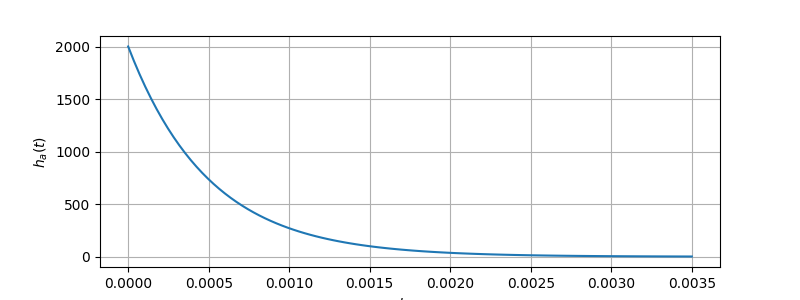

In [78]:
t, h_a = signal.impulse(lti_RC) # импульсная характеристика аналогового фильтра

plt.figure(figsize=[8, 3], dpi=100)
plt.plot(t, h_a)
plt.xlabel("$t$, c")
plt.ylabel("$h_a(t)$")
plt.grid()

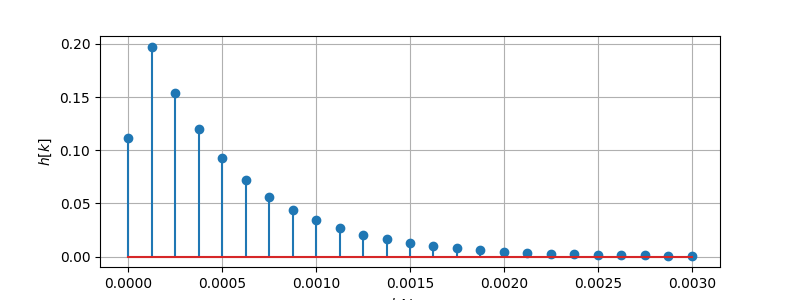

In [79]:
plt.figure(figsize=[8, 3], dpi=100)
t, h = signal.dimpulse(dlti_RC, n=25)
plt.stem(t, np.squeeze(h))
plt.xlabel("$k\\Delta t$, c")
plt.ylabel("$h[k]$")
plt.grid()

## Модуль 3. Метод инвариантной импульсной характеристики.

### Задача 3.1 Синтез аналога двухкаскадного RC-фильтра (II способ)

Построить БИХ фильтр, эквивалентный двум последовательно соединенным RC-цепочкам интегрирующего типа (соединённым через развязывающий усилитель), воспользовавшись методом инвариантной импульсной характеристики.

Параметры $RC$ и $\Delta t $ выбрать самостоятельно. 
Сравнить частотные и импульсные характеристики  цифровых фильтров и их аналоговых прототипов. 

**Начало решения.** 

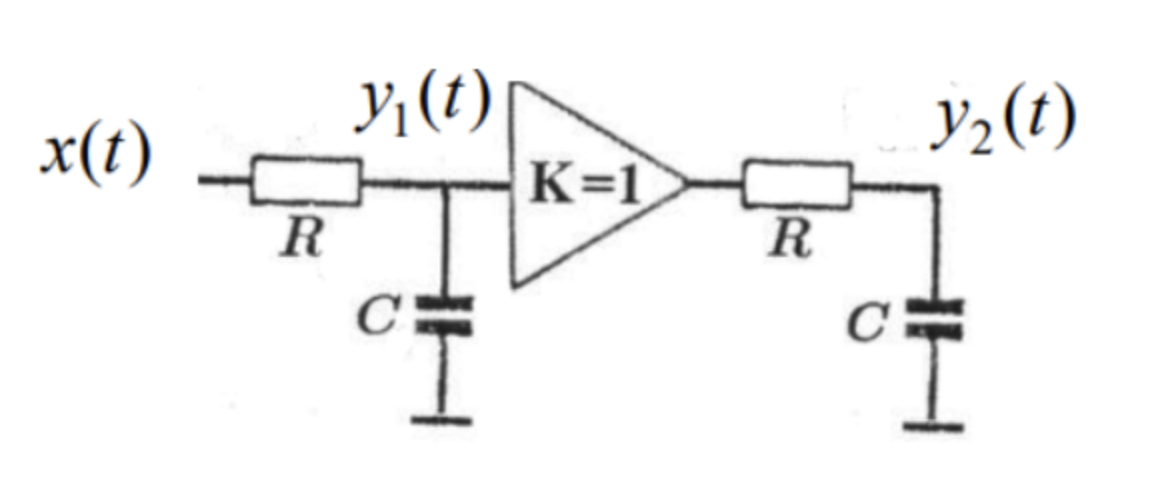

На рисунке между двумя  RC-цепочками  имеется  развязывающий повторитель, у которого большое входное и малое выходное сопротивление.  Это необходимо для устранения влияния цепочек друг на друга.

* Уравнение для одного RC-каскада:
$$RC\frac{dy}{dt}+{{y}_{1}}(t)=x(t)$$
Пусть ${{y}_{1}}(0)=0$. 

* Тогда преобразование Лапласа для него
$$RCp{{Y}_{1}}(p)+{{Y}_{1}}(p)=X(p)$$
* Передаточная функция
$${{H}_{1}}(p)=\frac{{{Y}_{1}}(p)}{X(p)}=\frac{1}{1+RCp}.$$

* Для двух последовательно соединенных RC-фильтров первого порядка
$${{H}_{2}}(p)={{H}_{1}}(p){{H}_{1}}(p)=\frac{1}{{{(RC)}^{2}}{{p}^{2}}+2RCp+1}.$$

Для аналогового фильтра импульсная характеристика может быть найдена с помощью обратного преобразования Лапласа для передаточной функции ${{H}_{a}}(p)$: 
$${{h}_{a}}(t)=\frac{1}{j2\pi }\oint\limits_{C}{{{H}_{a}}(p){{e}^{pt}}dp}, \qquad t\ge 0,$$
где контур $C$ охватывает все полюса подынтегральной функции. Для вычета в полюсе $m$-ого порядка воспользоваться формулой

$$\underset{{{z}_{p}}}{\mathop{\text{Res}}}\,\text{ }Y(z)=\frac{1}{(m-1)!}\text{ }\underset{z\to {{z}_{p}}}{\mathop{\lim }}\,\text{ }\frac{{{d}^{m-1}}}{d{{z}^{m-1}}}\left[ Y(z){{(z-{{z}_{p}})}^{m}} \right].$$

Дискретизовать импульсную характеристику по правилу  $h[k]=\Delta t\ {{h}_{a}}(k\Delta t)$ и с помощью $z$-преобразования найти передаточную функцию цифрового фильтра $H(z)$.

$$
h_a\left(t\right) = \dfrac{t}{\left(RC\right)^2}e^{-\frac{t}{RC}}
$$

$$
h[k] = \dfrac{k\Delta t^2}{\left(RC\right)^2}e^{-\frac{k\Delta t}{RC}}
$$

$$
H\left(z\right) = \dfrac{\Delta t^2}{\left(RC\right)^2} \sum_{k = 0}^{\infty} k\left(e^{-\frac{\Delta t}{RC}}z^{-1}\right)^k = \dfrac{\Delta t^2}{\left(RC\right)^2}\dfrac{ze^{\frac{\Delta t}{RC}}}{\left(ze^{\frac{\Delta t}{RC}} - 1\right)^2}
$$

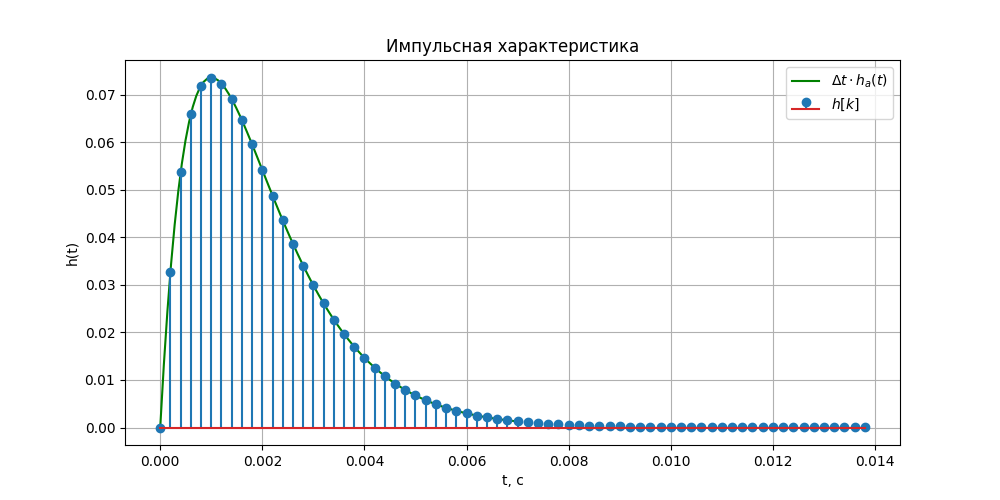

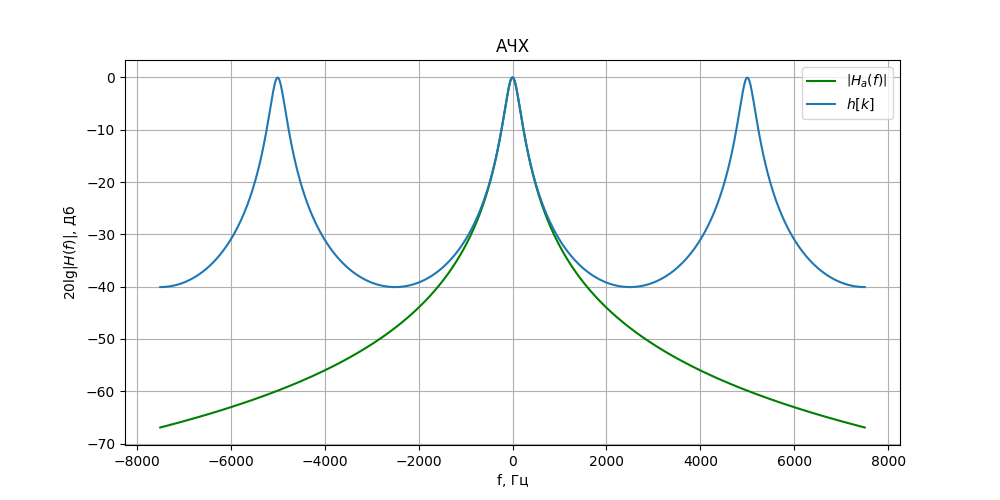

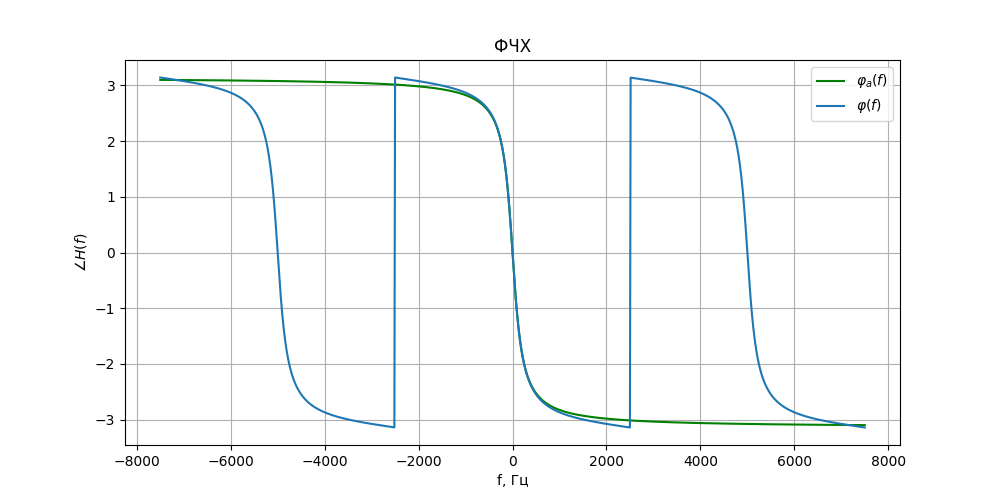

In [112]:
RC = 1e-3
fs = 5 / RC
dt = 1 / fs

lti = signal.lti([1], [RC**2, 2 * RC, 1])
dlti = Filter(
    (
        [0, (dt / RC) ** 2 * np.exp(-dt / RC), 0],
        [1, -2 * np.exp(-dt / RC), np.exp(-2 * dt / RC)],
    ),
    fs,
)

t, h = signal.impulse(lti)
tk, hd = signal.dimpulse(dlti.system_dlti, n=70)
plt.figure(figsize=[10, 5])
plt.plot(t, h * dt, "g", label="$\\Delta t \\cdot h_a(t)$")
plt.title("Импульсная характеристика")
plt.xlabel("t, с")
plt.ylabel("h(t)")
plt.stem(tk, np.squeeze(hd), label="$h[k]$")
plt.grid()
plt.legend()
plt.show()

wa, Ha = signal.freqresp(lti, w=np.linspace(-3 * np.pi, 3 * np.pi, 1000) / dt)
theta_d, Hd = signal.dfreqresp(
    dlti.system_dlti, w=np.linspace(-3 * np.pi, 3 * np.pi, 1000)
)
plt.figure(figsize=[10, 5])
plt.plot(
    wa / (2 * np.pi),
    20 * np.log10(abs(Ha)),
    "g",
    label="$\\left|H_a(f) \\right|$",
)
plt.title("АЧХ")
plt.xlabel("f, Гц")
plt.ylabel("$20 \\lg |H(f)|$, Дб")
plt.plot(theta_d / (2 * np.pi * dt), 20 * np.log10(abs(Hd)), label="$h[k]$")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[10, 5])
plt.plot(
    wa / (2 * np.pi),
    np.angle(Ha),
    "g",
    label="$\\varphi_a(f)$",
)
plt.title("ФЧХ")
plt.xlabel("f, Гц")
plt.ylabel("$\\angle H(f)$")
plt.plot(theta_d / (2 * np.pi * dt), np.angle(Hd), label="$\\varphi(f)$")
plt.grid()
plt.legend()

### Задача 3.2 Цифровая фильтрация реальных сигналов (творческая задача)

Творческая задача выполняется в одном из двух вариантов: вариант А (фильтрация сигнала из .wav файла) и вариант Б (фильтрация реального сигнала с цифрового осциллографа). Выбор варианта остается за студентом. *Плагиат при выполнении творческой задачи недопустим.*

#### Вариант А (фильтрация сигнала из .wav файла).
 
Выполнить фильтрацию `.wav` файла с помощью одного из цифровых фильтров, рассмотренных в первой и второй лабораторной работах. Проиллюстрировать, как в результате фильтрации изменился сигнал. Привести пример, для чего выбранный фильтр может быть применен. 

Для этой задачи `.wav` файл можно загрузить, например, с сайта [freesound.org](https://freesound.org/) или взять из предыдущих лабораторных работ.

*При выполнении творческой задачи в виде фильтрации звука из wav-файла необходимо составить аннотацию своей работы (5-6 предложений)*. Аннотацию необходимо поместить в свой ipynb файл и в таблицу https://disk.yandex.ru/i/Jo1Mx87rDMqGGQ .

#### Вариант Б (фильтрация реального сигнала с цифрового осциллографа).

В данном варианте задача выполняется на компьютерах в аудитории с использованием учебного цифрового осциллографа PV6501 (https://www.pv65.ru/6501/index.html). При выполнении творческой задачи по варианту Б составлять аннотацию не требуется.
Последовательность действий следующая. 
* Загрузить компьютер в аудитории под Windows 7.
* Запустить на нем управляющую программу цифрового осциллографа PV6501.
* Получить на время занятия два цифровых осциллографа PV6501 (обычно задание выполняется в парах по 2 студента).
* Выполнить калибровку уровня нуля на цифровом осциллографе. 
* Подключить генераторы осциллографов к схеме резисторного сумматора (плата выдается преподавателем). К выходу схемы подключить один из осциллографов. 
* Подать на входы схемы низкочастотные синусоиды, например, 5 и 10 кГц. Пронаблюдать сигнал суммы двух синусоид. 
* Записать осциллограмму в txt файл для дальнейшей обработки на python.
* Выполнить анализ сигнала.
* Выполнить фильтрацию сигнала на python. 
* Проанализировать сигнал после фильтрации. 

In [1]:
import scipy.io.wavfile
from IPython.display import Audio
fname = './sound.wav'
Audio(fname)

In [2]:
fs, x1 = scipy.io.wavfile.read(fname)
fs, x1

(48000, array([  75,   67,   68, ..., -130, -110, -130], dtype=int16))

In [3]:
x1.size

289102

In [4]:
x1.size/fs

6.022958333333333

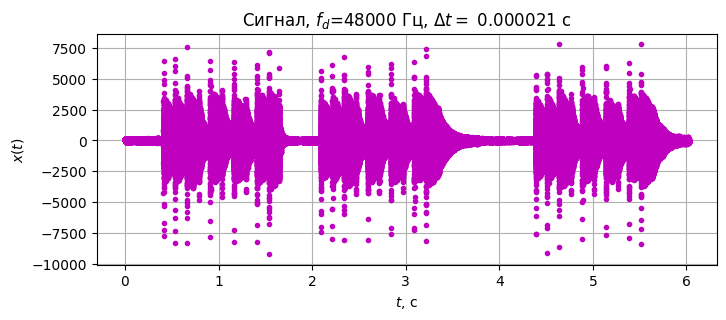

In [8]:
plt.figure(figsize=[8, 3])
plt.plot(np.arange(x1.size)/fs, x1, 'm.')
plt.xlabel(u'$t$, c')
plt.ylabel(u'$x(t)$')
plt.title('Сигнал, $f_d$=%i Гц, $\\Delta t=$ %f c' %(fs, 1.0/fs))
plt.grid()

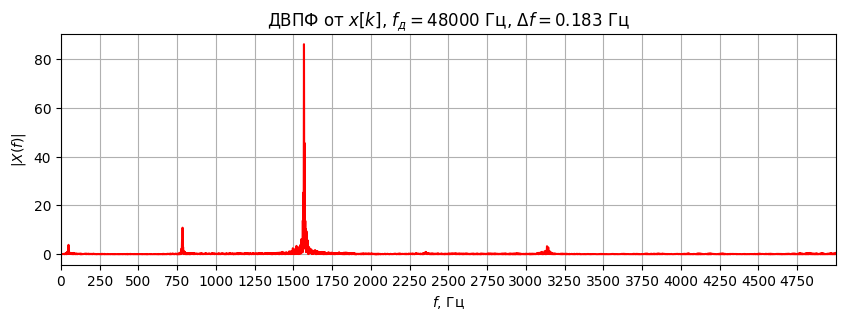

In [9]:
plt.figure(figsize=[10, 3], dpi=100)
M=4096*8*8
plt.plot((-0.5+(np.arange(M)/M))*fs, 
         abs(np.fft.fftshift(np.fft.fft(x1[int(fs*2.3):int(fs*2.8)], M)))/M, 
         'r')
plt.xticks(np.arange(0, 5000, 250))
plt.xlim([0, 5000])
plt.title(u'ДВПФ от $x[k]$, $f_д=%d$ Гц, $\\Delta f=%.3f$ Гц' %(fs, fs/M))
plt.xlabel(u'$f$, Гц')
plt.ylabel(u'$|X(f)|$')
plt.grid()

In [10]:
f_0_list = [168, 516, 884, 1226, 1677]
y_out = np.zeros(x1.size)
for f_0 in f_0_list:
    beta, alpha = signal.iirpeak(f_0, Q=100, fs=fs)
    y_out += signal.lfilter(beta, alpha, x1)
y_out /= len(f_0_list)

In [11]:
Audio(data=y_out, rate=fs)

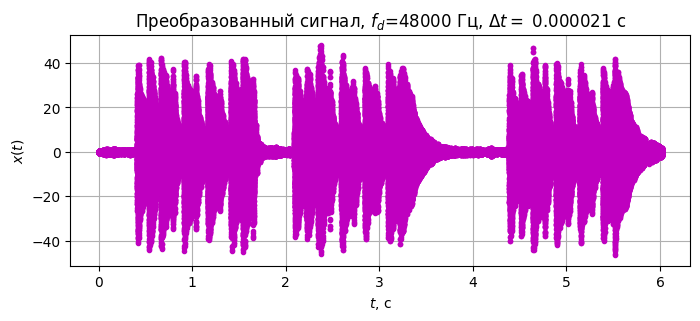

In [12]:
plt.figure(figsize=[8, 3])
plt.plot(np.arange(x1.size)/fs, y_out, 'm.')
plt.xlabel(u'$t$, c')
plt.ylabel(u'$x(t)$')
plt.title('Преобразованный сигнал, $f_d$=%i Гц, $\\Delta t=$ %f c' %(fs, 1.0/fs))
plt.grid()

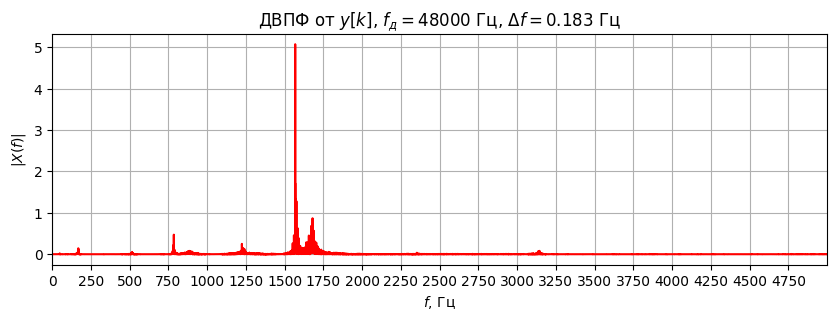

In [13]:
plt.figure(figsize=[10, 3], dpi=100)
M=4096*8*8
plt.plot((-0.5+(np.arange(M)/M))*fs, 
         abs(np.fft.fftshift(np.fft.fft(y_out, M)))/M, 
         'r')
plt.xticks(np.arange(0, 5000, 250))
plt.xlim([0, 5000])
plt.title(u'ДВПФ от $y[k]$, $f_д=%d$ Гц, $\\Delta f=%.3f$ Гц' %(fs, fs/M))
plt.xlabel(u'$f$, Гц')
plt.ylabel(u'$|X(f)|$')
plt.grid()

В качестве фильтра в задании были использованы несколько наложенных цифровых резонаторов. С помощью полученного фильтра из звуковой дорожки, содержащей удар в колокол на фоне шума, был изолирован удар в колокол. Данная дорожка была выбрана как первая, из которой получилось достать какой-либо отдельный звук, который может быть интересным. Полученный звук кажется достаточно чистым, однако все равно сохранились некоторые шумы. На графике ДВПФ явно видно изолированные частоты, которые были выбраны по пикам на ДВПФ участка исходного сигнала, на котором содержится удар.